<a href="https://colab.research.google.com/github/Natasha-29/--3-./blob/master/%D0%A8%D0%B0%D1%84%D0%BE%D1%80%D0%BE%D1%81%D1%82_%D0%9D%D0%92_%22%D0%9F%D0%A0%D0%9E%D0%93_5_%D0%9B%D0%A0_%D0%97%D0%B0%D1%89%D0%B8%D1%82%D0%B0%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 5

Описание работы: получить данные о погоде за 5 последних дней и визуализировать эти данные, используя диаграмму рассеяния (scatterplot). Затем, посчитать среднюю температуру за каждый день и построить рядом (на этом же изображении) линейную диаграмму изменения температур.

Начнем с части 1: получим данные в формате json через API openweathermap

In [ ]:
key = 'e48674a3824c7010b223ba7f1086be72'

In [ ]:
def getweather(api_key=None, dt=None):
    import json
    import requests
    city, lat, lon = "Saint Petersburg, RU", 59.57, 30.19


    if api_key:
        result = dict()
        req = requests.get(
            f'http://api.openweathermap.org/data/2.5/'
            f'onecall/timemachine?lat={lat}&lon={lon}&dt={dt}&'
            f'appid={api_key}&lang=ru&units=metric')

        req_obj = json.loads(req.text)  # Преобразуем объект типа Request в json-формат

        # Сохраним результаты температур в формате json, чтобы ниже их визуализировать
        result['city'] = city
        measures = [{"dt": str(measure['dt']), "temp": str(measure['temp'])} for measure in req_obj["hourly"]]
        

        result['temps'] = measures
        return json.dumps(result)

weather_data_json = getweather(key, 1655424000)

Перейдем к шагу 2: визуализируем полученные данные с помощью matplotlib и типа диаграммы scatterplot.

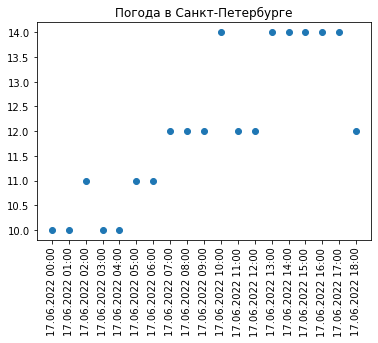

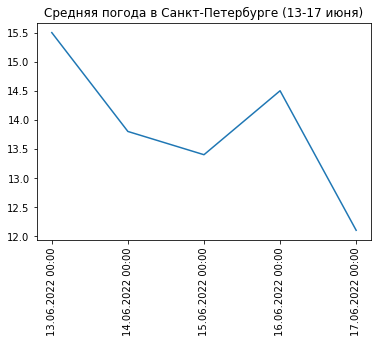

In [ ]:
def visualise_data(json_data=''):

    if json_data:
        import matplotlib.pyplot as pplt
        import pandas
        from datetime import datetime
        import numpy as np
        # Мы можем загрузить данные в пригодный для дальнейшей обработки формат
        # с помощью метода read_json из pandas.
        data = pandas.read_json(json_data)
        # print(data)
        city_name = data['city']

        # получим отдельные столбцы с датами 
        dates = [_d['dt'] for _d in data['temps'][:]]
        # и тепературами
        temps = [_t['temp'] for _t in data['temps'][:]]

        # построенный график необходимо оптимизировать:
        #  - упростить вывод дат (на этом графике они выводятся в формате unixtime)
        #  - вывести более строгие значения для подписей осей абсцисс и ординат
        dates_upd = [datetime.utcfromtimestamp(int(i)).strftime('%d.%m.%Y %H:%M') for i in dates]
        temps_upd = [round(float(i)) for i in temps]

        x_pos = np.arange(len(dates_upd))
        #  - добавить название 
        pplt.title('Погода в Санкт-Петербурге')
        #  - правильно расположить ось абсцисс
        #  (xticks, yticks)
        pplt.xticks(x_pos, dates_upd, rotation = 90)
         
        
        # - добавить на график температуры остальных дат 
        # - добавить второй график со средними значениями

        # построим их на диаграмме рассеяния
        pplt.scatter(x_pos, temps_upd)
        pplt.show()

visualise_data(weather_data_json)


# средние температуры
from datetime import datetime
import matplotlib.pyplot as pplt
import numpy as np
import pandas

def average_temp(dates):

    res_dict = {}
    res = []
    for i in dates:
        res_dict[i] = pandas.read_json(getweather(key, i))
        res_dict[i] = round(np.mean([float(_t['temp']) for _t in res_dict[i]['temps'][:]]), 1)

    res = [res_dict[i] for i in res_dict]
    return res



dates = [1655078400, 1655164800, 1655251200, 1655337600, 1655424000] 
res = average_temp(dates)
# print(res)

dates_upd = [datetime.utcfromtimestamp(int(i)).strftime('%d.%m.%Y %H:%M') for i in dates]
x_pos = np.arange(len(dates_upd))

pplt.title('Средняя погода в Санкт-Петербурге (13-17 июня)')
pplt.xticks(x_pos, dates_upd, rotation = 90)
pplt.plot(x_pos, res)
pplt.show()

# Лабораторная работа 6

Примените паттерн одиночка к функции получения валют и протестируйте получившийся код (при применении шаблона у вас не может существовать более одного инстанса объекта, к которому вы применили паттерн). 

У класса есть только один экземпляр, и он предоставляет к нему глобальную точку доступа. При попытке создания данного объекта он создаётся только в том случае, если ещё не существует, в противном случае возвращается ссылка на уже существующий экземпляр и нового выделения памяти не происходит.

In [ ]:
"""
Разработать фрагмент программы, позволяющий получать данные о текущих курсах валют с сайта Центробанка РФ с использованием сервиса, который они предоставляют. Применить шаблон проектирования «Одиночка» для предотвращения отправки избыточных запросов к серверу ЦБ РФ (запретить вызов функции get_currencies более 1 раза в секунду). Оформить решение в виде корректно работающего приложения, реализовать тестирование и опубликовать его в портфолио.

Страница документации: https://cbr.ru/development/
"""

# http://www.cbr.ru/scripts/XML_daily.asp
import time
import requests
from xml.etree import ElementTree as ET  


def singleton(cls):
    instances = {}

    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]

    return getinstance


class TooManyRequests(Exception):
    pass


@singleton
class CurrenciesList():
    def __init__(self):
        self.t = 0
        

    def get_currencies(self, currencies_ids_lst=None):
        t = time.time() # время, выраженное в секундах с начала.

        if t - self.t < 1:
            raise TooManyRequests('one function call per second is allowed')

        self.t = t
        
        if currencies_ids_lst is None:
            currencies_ids_lst = [
                'R01239', 'R01235', 'R01035', 'R01815', 'R01585F', 'R01589',
                'R01625', 'R01670', 'R01700J', 'R01710A'
            ]
        res = requests.get("http://www.cbr.ru/scripts/XML_daily.asp")
        cur_res_str = res.text

        result = {}

        root = ET.fromstring(cur_res_str) # находим корень

        valutes = root.findall("Valute") # используется для поиска всех непересекающихся совпадений в шаблоне

        for _v in valutes:
            valute_id = _v.get('ID')

            if str(valute_id) in currencies_ids_lst: # если номер валюты есть в нашем списке сохраняем его
                valute_cur_val = _v.find('Value').text
                valute_cur_name = _v.find('Name').text

                result[valute_id] = (valute_cur_val, valute_cur_name)

        return result



    

In [ ]:
    my_cur_list = CurrenciesList()
    print(id(my_cur_list))
    
    my_cur_list2 = CurrenciesList()
    res = my_cur_list2.get_currencies(["R01090B", "R01720", "R01565"])
    print(res)
    print(id(my_cur_list2))
    
    time.sleep(1.0)
    
    my_cur_list3 = CurrenciesList()
    print(id(my_cur_list3))
    res = my_cur_list3.get_currencies(["R01090B", "R01720", "R01565"])
    print(res)

140223699418384
{'R01090B': ('22,1152', 'Белорусский рубль'), 'R01565': ('12,6438', 'Польский злотый'), 'R01720': ('19,1990', 'Украинских гривен')}
140223699418384
140223699418384
{'R01090B': ('22,1152', 'Белорусский рубль'), 'R01565': ('12,6438', 'Польский злотый'), 'R01720': ('19,1990', 'Украинских гривен')}


# Лабораторная работа 7

Примените паттерн декоратор и реализуйте объектно-ориентированную версию программы получения курсов валют с сайта Центробанка таким образом, чтобы:



In [ ]:
import requests
import json
import csv
from bs4 import BeautifulSoup

In [ ]:
class BaseComponent(): # объявляем наш "интерфейс" от которого будут наследоваться декораторы
  def get_currencies():
    pass

In [ ]:
class Decorator(BaseComponent): # объявляем базовый класс декоратора
    __component = BaseComponent() # который наследуется от нашего интерфейса

    def __init__(self, component): # в качестве аргумента конструктора передаётся объект
        self.__component = component # наследуемый от BaseComponent

In [ ]:
class CurrenciesList(BaseComponent):

    def get_currencies(self, currencies_ids_lst=None):
        if currencies_ids_lst is None:
            currencies_ids_lst = [
                'R01239', 'R01235', 'R01035', 'R01815', 'R01585F', 'R01589',
                'R01625', 'R01670', 'R01700J', 'R01710A'
            ]
        cur_res_str = requests.get("http://www.cbr.ru/scripts/XML_daily.asp").text
        result={}
        soup = BeautifulSoup(cur_res_str, 'html.parser')


        valutes = soup.find_all("valute")
        for _v in valutes:
            valute_id = _v['id']
            
            if str(valute_id) in currencies_ids_lst:
                valute_cur_val = _v.find('value').string
                valute_cur_name = _v.find('name').string

                result[valute_id] = (valute_cur_val, valute_cur_name)
        return result


было возможно применить декоратор к базовой версии и получить данные в формате JSON (class ConcreteDecoratorJSON);

In [ ]:
class DecoratorJSON(Decorator): # объявляем декоратор, который записывает результат в json
    __component = BaseComponent() 

    def __init__(self, component): # в качестве аргумента конструктора передаётся объект 
        self.__component = component # наследуемый от BaseComponent

    def dict_to_json(self):
        dct = self.__component.get_currencies(["R01090B", "R01720", "R01565"])
        with open('result.json', 'w') as fp:
            json.dump(dct, fp, indent = 4, ensure_ascii=False)


было возможно использовать декоратор к базовой версии (CurrenciesList) или к другому декоратору (ConcreteDecoratorJSON) и получить данные в формате csv (class ConcreteDecoratorCSV).

In [ ]:
class DecoratorCSV(Decorator): # объявляем декоратор, который записывает результат в csv
    __component = BaseComponent()

    def __init__(self, component): # в качестве аргумента конструктора передаётся объект 
        self.__component = component # наследуемый от BaseComponent

    def dict_to_csv(self):
        dct = self.__component.get_currencies(["R01090B", "R01720", "R01565"])
        with open('result.csv', 'w') as fp:
            w = csv.DictWriter(fp, dct.keys())
            w.writeheader()
            w.writerow(dct)

In [ ]:
cur_lst_json = DecoratorJSON(CurrenciesList()) # создаем объект класса CurrenciesList и передаём его декоратору DecoratorJSON
cur_lst_json.dict_to_json() # таким образом созданный объект имеет функциональность, описанную в декораторе DecoratorJSON

In [ ]:
cur_lst_csv = DecoratorCSV(CurrenciesList()) # создаем объект класса CurrenciesList и передаём его декоратору DecoratorCSV
cur_lst_csv.dict_to_csv() # таким образом созданный объект имеет функциональность, описанную в декораторе DecoratorCSV


# Лабораторная работа 9

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date, timedelta
import requests
from bs4 import BeautifulSoup

In [ ]:
def get_currencies(currencies_ids_lst =[ 
            'R01239', 'R01235', 'R01035', 'R01815', 'R01585F', 'R01589',
            'R01625', 'R01670', 'R01700J', 'R01710A'
        ]): # получение значений валют, которые передаются списком в функцию

    cur_res_str = requests.get("http://www.cbr.ru/scripts/XML_daily.asp").text # отправка запроса на апи и преобразование ответа в текст
    result = dict()
    # парсим данные и извлекаем необходимые валюты 
    soup = BeautifulSoup(cur_res_str, 'html.parser') 
    valutes = soup.find_all("valute")
    for _v in valutes:
        valute_id = _v['id']
            
        if str(valute_id) in currencies_ids_lst:
            valute_cur_val = _v.find('value').string
            valute_cur_name = _v.find('name').string
            result[valute_cur_name] = valute_cur_val

    return result


In [ ]:
# Вывести на графике 10 валют (получить по кодам валюты из ЦБС)

cur_vals = get_currencies() #получаем  
objects = cur_vals.keys() #метод .keys() возвращает список со всеми ключами

y_pos = np.arange(len(objects))

In [ ]:
# переписать лямбда-функцию из следующей строки через list comprehension 
# performance = list(map(lambda x: float(x.replace(",",".")), cur_vals.values()))

performance = [float(x.replace(',', '.')) for x in cur_vals.values()]

In [ ]:
# Нарисовать отдельный график с колебанием одной (выбранной вами) валюты
# (получить данные с сайта ЦБ за год) и отобразить его наиболее 
# оптимальным образом (типом графика)

def get_currencies_year(currencie_id='R01239'): # функция получения валюты за год

    today = datetime.today() # берём сегодняшнюю дату
    date = today - timedelta(days=365) # находим начальную дату: сегодняшняя - 365 деней
    result = dict()
    valute_name = "Евро"

    while date !=today: # итерируемся по циклу 365 раз, отправляя каждый раз запрос

        day = str(date.day)
        month = str(date.month)

        if len(str(date.day)) == 1: # так как по запросу ожидается формат дд:мм:гггг то стоит проверять является ли число однозначным
            day = '0' + str(date.day) # если является, то приписать к началу 0, иначе в качестве ответа придёт ошибка
        
        if len(str(date.month)) == 1: # аналогично также как и с числом выше
            month = '0' + str(date.month)

        req = requests.get('http://www.cbr.ru/scripts/XML_daily.asp', params = {'date_req':day + '/' + month + '/' + str(date.year)}).text # отправка запроса

        soup = BeautifulSoup(req, 'html.parser') # парсинг необходимой валюты
        valutes = soup.find_all("valute")

        for _v in valutes:
            valute_id = _v['id']
                
            if str(valute_id) == currencie_id:
                valute_val = float('.'.join(_v.find('value').string.split(',')))
                result[date.strftime("%d/%m/%Y")] = valute_val

        date = date + timedelta(days = 1) # добавление одного дня к итерируемой переменной

    res = {valute_name:result}
    return res



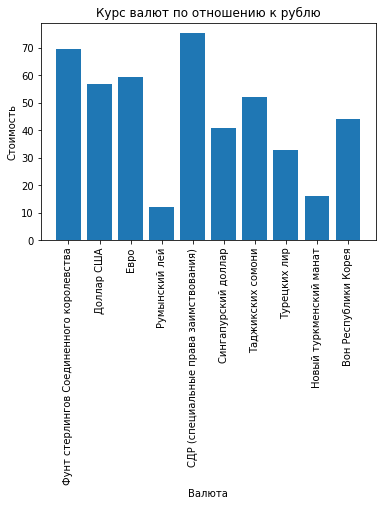

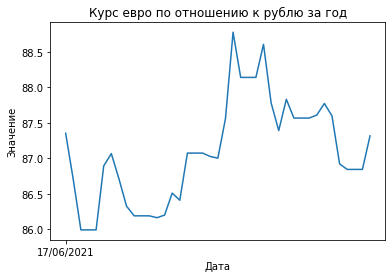

In [ ]:
# Отобразить это на одном изображении (2 графика)

plt.bar(y_pos, performance)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Стоимость')
plt.xlabel('Валюта')
plt.title('Курс валют по отношению к рублю')
plt.show()

year_currencies = get_currencies_year()
x = []
y = []

for n in list(year_currencies["Евро"].items()):
    x.append(n[0])
    y.append(n[1])

plt.plot(x,y)
plt.title("Курс евро по отношению к рублю за год")
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.xticks(x[::80])
plt.autoscale(tight=False)
plt.show()